In [1]:
import pandas as pd
import numpy as np
import io
import requests
from sklearn.impute import SimpleImputer


# mushrooms dataset
url = "https://www.wolframcloud.com/obj/d0c0084e-0b60-46db-a4d9-beb33412905e"
s = requests.get(url).content
data = pd.read_csv(io.StringIO(s.decode('utf-8')))
data.head()

,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,StalkShape,StalkRoot,StalkSurfaceAboveRing,StalkSurfaceBelowRing,StalkColorAboveRing,StalkColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporePrintColor,Population,Habitat,Class
0,convex,smooth,brown,True,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,1,pendant,black,scattered,urban,poisonous
1,convex,smooth,yellow,True,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,1,pendant,brown,numerous,grasses,edible
2,bell,smooth,white,True,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,1,pendant,brown,numerous,meadows,edible
3,convex,scaly,white,True,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,1,pendant,black,scattered,urban,poisonous
4,convex,smooth,gray,False,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,1,evanescent,brown,abundant,grasses,edible


**Подготовка набора данных**

**Dataset preparation**

In [2]:
rows, columns = data.shape
print('rows = {}; columns = {}'.format(rows, columns), '\n\n')

# go through each dataset column and check unique values to find empty one (like NaN or Missing[])
for col in data.columns:
  print('{}: {}'.format(col, data[col].unique()))

rows = 8124; columns = 23 


CapShape: ['convex' 'bell' 'sunken' 'flat' 'knobbed' 'conical']
CapSurface: ['smooth' 'scaly' 'fibrous' 'grooves']
CapColor: ['brown' 'yellow' 'white' 'gray' 'red' 'pink' 'buff' 'purple' 'cinnamon'
 'green']
Bruises: [ True False]
Odor: ['pungent' 'almond' 'anise' 'none' 'foul' 'creosote' 'fishy' 'spicy'
 'musty']
GillAttachment: ['free' 'attached']
GillSpacing: ['close' 'crowded']
GillSize: ['narrow' 'broad']
GillColor: ['black' 'brown' 'gray' 'pink' 'white' 'chocolate' 'purple' 'red' 'buff'
 'green' 'yellow' 'orange']
StalkShape: ['enlarging' 'tapering']
StalkRoot: ['equal' 'club' 'bulbous' 'rooted' 'Missing[]']
StalkSurfaceAboveRing: ['smooth' 'fibrous' 'silky' 'scaly']
StalkSurfaceBelowRing: ['smooth' 'fibrous' 'scaly' 'silky']
StalkColorAboveRing: ['white' 'gray' 'pink' 'brown' 'buff' 'red' 'orange' 'cinnamon' 'yellow']
StalkColorBelowRing: ['white' 'pink' 'gray' 'buff' 'brown' 'red' 'yellow' 'orange' 'cinnamon']
VeilType: ['partial']
VeilColor: ['whit

In [3]:
"""
on initial viewing it seems that we have single column
with absence of values in rows: this column is StalkRoot and
absence of values is indicated like Missing[]
"""

# Take a look at columns more precisely to ensure that this column is single with absence of values
for col in data.columns:
    # Missing[] amount 
    temp_null_count = data[data[col] == 'Missing[]'].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        temp_perc = round((temp_null_count / rows) * 100.0, 2)
        print('Column {}. Data type {}. amount of Missing[] values {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Column StalkRoot. Data type object. amount of Missing[] values 2480, 30.53%.


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [4]:
data['StalkRoot'].unique()

array(['equal', 'club', 'bulbous', 'rooted', 'Missing[]'], dtype=object)

In [5]:
# impute data with most frequent values
imputation = SimpleImputer(missing_values='Missing[]', strategy='most_frequent')
data_imputed = imputation.fit_transform(data[['StalkRoot']])
np.unique(data_imputed)

array(['bulbous', 'club', 'equal', 'rooted'], dtype=object)

In [6]:
# put imputed data in our dataset
for i in range(rows):
  data['StalkRoot'][i] = data_imputed[i][0]
data['StalkRoot'].unique()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array(['equal', 'club', 'bulbous', 'rooted'], dtype=object)

In [7]:
# now we`ll transform categorical columns to columns with values in [0, 1]
object_columns = []

# initially, find amount of unique values for each column
# and add categorical columns to object_columns
for column in data.columns:
    dt = str(data[column].dtype)
    amount_unique = len(pd.unique(data[column]))
    print('{}: {}, {}'.format(column, amount_unique, dt))
    if dt == 'object':
        object_columns.append({'column': column, 'amount': amount_unique})

CapShape: 6, object
CapSurface: 4, object
CapColor: 10, object
Bruises: 2, bool
Odor: 9, object
GillAttachment: 2, object
GillSpacing: 2, object
GillSize: 2, object
GillColor: 12, object
StalkShape: 2, object
StalkRoot: 4, object
StalkSurfaceAboveRing: 4, object
StalkSurfaceBelowRing: 4, object
StalkColorAboveRing: 9, object
StalkColorBelowRing: 9, object
VeilType: 1, object
VeilColor: 4, object
RingNumber: 3, int64
RingType: 5, object
SporePrintColor: 9, object
Population: 6, object
Habitat: 7, object
Class: 2, object


In [0]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [0]:
"""
after oneHot encoding for single value we`ll have something like this [0.0, 1.0, 0.0, 0.0, ...]
but we need to have just a number - so this function will normalize it with next formula:
norm_val = (N - i) / N, where
N - amount of unique values for our column
i - index of 1.0 in values [0.0, 1.0, 0.0, 0.0, ...] before normalizing
so for example if we`ll have 10 different values - then in normalized view it will variating
from 0.1 (if index = 9) to 1.0 (if index = 0)
"""
def from_bytes_to_num(col_in_arr, uniquie_amount):
    normalized_col = []
    for value in col_in_arr:
        normalized_value = (uniquie_amount - np.where(value == 1.0)[0][0]) / uniquie_amount
        normalized_col.append(float("{0:.4f}".format(normalized_value))) # digits after float point
    return normalized_col


normalized_data = []
for col in object_columns:
    uniquie_amount = col['amount']
    col_name = col['column']

    #encode with oneHot
    column_after_encoding = ohe.fit_transform(data[[col_name]])

    #fetch it to array
    col_in_arr = column_after_encoding.toarray()

    #normilizing column values
    normalized_col = from_bytes_to_num(col_in_arr, uniquie_amount)

    normalized_data.append({'column': col_name, 'data': normalized_col})

In [10]:
#set normalized values for general dataset
for col in normalized_data:
    col_in_dataFrame = pd.DataFrame(data={col['column']: col['data']})
    data[col['column']] = col_in_dataFrame

data

,CapShape,CapSurface,CapColor,Bruises,Odor,GillAttachment,GillSpacing,GillSize,GillColor,StalkShape,StalkRoot,StalkSurfaceAboveRing,StalkSurfaceBelowRing,StalkColorAboveRing,StalkColorBelowRing,VeilType,VeilColor,RingNumber,RingType,SporePrintColor,Population,Habitat,Class
0,0.6667,0.25,1.0,True,0.2222,0.5,1.0,0.5,1.0000,1.0,0.50,0.25,0.25,0.2222,0.2222,1.0,0.50,1,0.2,1.0000,0.5000,0.4286,0.5
1,0.6667,0.25,0.1,True,1.0000,0.5,1.0,1.0,1.0000,1.0,0.75,0.25,0.25,0.2222,0.2222,1.0,0.50,1,0.2,0.8889,0.6667,1.0000,1.0
2,1.0000,0.25,0.2,True,0.8889,0.5,1.0,1.0,0.9167,1.0,0.75,0.25,0.25,0.2222,0.2222,1.0,0.50,1,0.2,0.8889,0.6667,0.7143,1.0
3,0.6667,0.50,0.2,True,0.2222,0.5,1.0,0.5,0.9167,1.0,0.50,0.25,0.25,0.2222,0.2222,1.0,0.50,1,0.2,1.0000,0.5000,0.4286,0.5
4,0.6667,0.25,0.7,False,0.3333,0.5,0.5,1.0,1.0000,0.5,0.50,0.25,0.25,0.2222,0.2222,1.0,0.50,1,1.0,0.8889,1.0000,1.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0.3333,0.25,1.0,False,0.3333,1.0,1.0,1.0,0.0833,1.0,1.00,0.25,0.25,0.5556,0.5556,1.0,0.75,1,0.2,0.7778,0.8333,0.8571,1.0
8120,0.6667,0.25,1.0,False,0.3333,1.0,1.0,1.0,0.0833,1.0,1.00,0.25,0.25,0.5556,0.5556,1.0,1.00,1,0.2,0.7778,0.3333,0.8571,1.0
8121,0.5000,0.25,1.0,False,0.3333,1.0,1.0,1.0,0.9167,1.0,1.00,0.25,0.25,0.5556,0.5556,1.0,0.75,1,0.2,0.7778,0.8333,0.8571,1.0
8122,0.3333,0.50,1.0,False,0.6667,0.5,1.0,0.5,0.8333,0.5,1.00,0.25,0.50,0.2222,0.2222,1.0,0.50,1,1.0,0.2222,0.3333,0.8571,0.5


**Разделение данных**

**Data splitting**

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

dcopy = data.copy()

X = dcopy.drop("Class", axis=1)
y = dcopy["Class"]
print(X.head(), "\n")
print(y.head())

   CapShape  CapSurface  CapColor  ...  SporePrintColor  Population  Habitat
0    0.6667        0.25       1.0  ...           1.0000      0.5000   0.4286
1    0.6667        0.25       0.1  ...           0.8889      0.6667   1.0000
2    1.0000        0.25       0.2  ...           0.8889      0.6667   0.7143
3    0.6667        0.50       0.2  ...           1.0000      0.5000   0.4286
4    0.6667        0.25       0.7  ...           0.8889      1.0000   1.0000

[5 rows x 22 columns] 

0    0.5
1    1.0
2    1.0
3    0.5
4    1.0
Name: Class, dtype: float64


In [12]:
# divide train and test selections
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6093, 22)
(2031, 22)
(6093,)
(2031,)


**Обучение моделей**

**Models training**

In [0]:
# checking metricks of the model
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score

def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

**Линейная модель — Lasso**

**Linear model — Lasso**

In [26]:
from sklearn.linear_model import Lasso, LinearRegression


las_1 = Lasso(alpha=1.0)
las_1.fit(X_train, y_train)
test_model(las_1)

mean_absolute_error: 0.24994854496806154
median_absolute_error: 0.2383883144592155
r2_score: -0.0017653308163576575


**SVM**

In [94]:
from sklearn.svm import NuSVR


nusvr_05 = NuSVR(nu=0.5, gamma='scale')
nusvr_05.fit(X_train, y_train)
test_model(nusvr_05)

mean_absolute_error: 0.000534966386468839
median_absolute_error: 0.00015048447756371708
r2_score: 0.9999126628428283


**Дерево решений**

**Decision tree**

In [47]:
from sklearn.tree import DecisionTreeRegressor


dt_6 = DecisionTreeRegressor(max_depth=6)
dt_6.fit(X_train, y_train)
test_model(dt_6)

mean_absolute_error: 0.0
median_absolute_error: 0.0
r2_score: 1.0


In [48]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

# Structure of decision tree we got
stat_tree(dt_6)

Всего узлов: 27
Листовых узлов: 14
Глубина дерева: 6
Минимальная глубина листьев дерева: 2
Средняя глубина листьев дерева: 4.357142857142857


**Подбор гиперпараметра $K$**

**Selection of hyperparameter $K$**

**Lasso**

In [82]:
param_range = np.arange(0.0, 0.1, 0.001)
tuned_parameters = [{'alpha': param_range}]
tuned_parameters

[{'alpha': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
         0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
         0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
         0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
         0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
         0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
         0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
         0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
         0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
         0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
         0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
         0.099])}]

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


gs = GridSearchCV(Lasso(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.69040267838188, tolerance: 0.05070940423436683
  positive)


Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

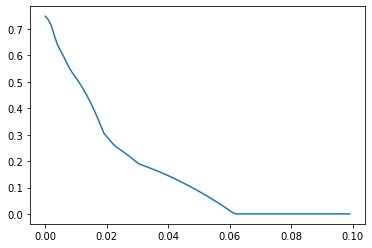

In [84]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve

plt.plot(param_range, gs.cv_results_["mean_train_score"]);

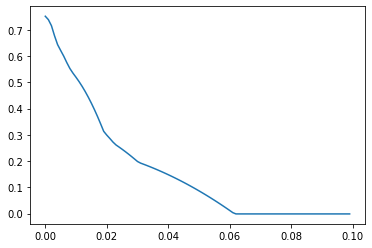

In [85]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [86]:
reg = LinearRegression()
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.08340159869364022
median_absolute_error: 0.05722169623926676
r2_score: 0.7608112307370376


**SVM**

In [95]:
param_range = np.arange(0.0, 1.0, 0.1)
tuned_parameters = [{'nu': param_range}]
tuned_parameters

[{'nu': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}]

In [96]:
gs = GridSearchCV(NuSVR(gamma='scale'), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.2, shrinking=True, tol=0.001, verbose=False)

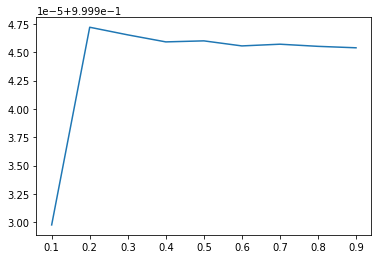

In [97]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

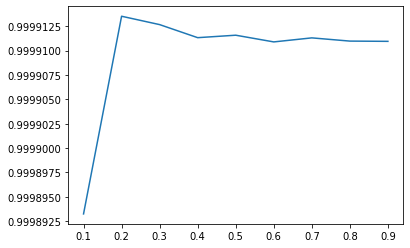

In [98]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

**Decision tree**

In [103]:
param_range = np.arange(1, 17, 1)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])}]

In [104]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

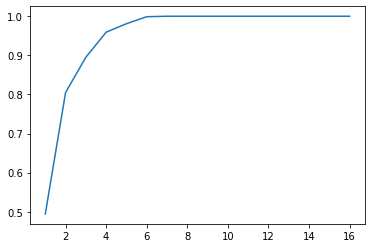

In [105]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

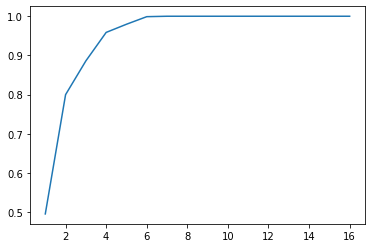

In [106]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [111]:
param_range = np.arange(1, 9, 1)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8])}]

In [112]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

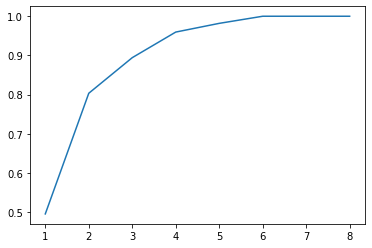

In [113]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

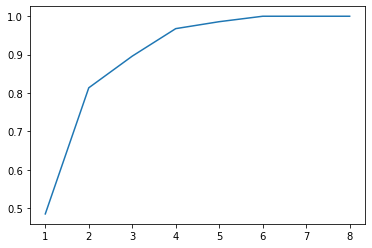

In [114]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);